## COMP5625M Assessment 1 - Image Classification

<div class="logos"><img src="https://drive.google.com/uc?id=132BXgkV5w1bpXlVpdr5BtZdpagqYvna7" width="220px" align="right"></div>

### Motivation 

Through this assessment, you will gain practical experience in:

> 1. Implementing and evaluating a multi-layer perceptron (MLP) and convolutional neural network (CNN) in solving a classification problem
> 2. Building, evaluating, and finetuning a CNN on an image dataset from development to testing 
> 3. Tackling overfitting using strategies such as data augmentation and drop out
> 4. Fine tuning a model 
> 5. Comparing the performance of a new model with an off-the-shelf model (AlexNet)
> 6. Gaining a deeper understanding of model performance using visualisations from Grad-CAM.


### Setup and resources 

You must work using this template notebook.

Having a GPU will speed up the training process. See the provided document on Minerva about setting up a working environment for various ways to access a GPU. We highly recommend you use platforms such as Colab.

Please implement the coursework using **Python and PyTorch**, and refer to the notebooks and exercises provided.

This coursework will use a subset of images from Tiny ImageNet, which is a subset of the [ImageNet dataset](https://www.image-net.org/update-mar-11-2021.php). Our subset of Tiny ImageNet contains **30 different categories**, we will refer to it as TinyImageNet30. The training set has 450 resized images (64x64 pixels) for each category (13,500 images in total). You can download the training and test set from a direct link or the Kaggle challenge website:

>[Direct access to data is possible by clicking here, please use your university email to access this](https://leeds365-my.sharepoint.com/:u:/g/personal/scssali_leeds_ac_uk/ESF87mN6kelIkjdISkaRow8BublW27jB-P8eWV6Rr4rxtw?e=SPASDB)

>[Access data through Kaggle webpage](https://www.kaggle.com/t/917fe52f6a3c4855880a24b34f26db07) 


### Required submissions

##### 1. Kaggle Competition
To participate in the submission of test results, you will need an account. Even if you have an existing Kaggle account, please carefully adhere to these instructions, or we may not be able to locate your entries:

> 1. Use your **university email** to register a new account.
> 2. Set your **Kaggle account NAME** to your university username, for example, ``sc15jb``.

The class Kaggle competition also includes a blind test set, which will be used in Question 1 for evaluating your custom model's performance on a test set. The competition website will compute the test set accuracy, as well as position your model on the class leaderboard. [Link to submit your results on Kaggle competition](https://www.kaggle.com/competitions/comp5623m-artificial-intelligence/submissions). 

Please submit only your predictions from test set - detailed instructions are provided in (3)

##### 2. Submission of your work

Please submit the following:

> 1. Your completed Jupyter notebook file, without removing anything in the template, in **.ipynb format.**
> 2. The **.html version** of your notebook; File > Download as > HTML (.html). Check that all cells have been run and all outputs (including all graphs you would like to be marked) displayed in the .html for marking.
> 3. Your selected image from section 2.4.2 "Failure analysis".

**Final note:**

> **Please display everything that you would like to be marked. Under each section, put the relevant code containing your solution. You may re-use functions you defined previously, but any new code must be in the relevant section.** Feel free to add as many code cells as you need under each section.


--> Kritin Senaprame

## Required packages

[1] [numpy](http://www.numpy.org) is a package for scientific computing with python

[2] [h5py](http://www.h5py.org) is a package to interact with compactly stored dataset

[3] [matplotlib](http://matplotlib.org) can be used for plotting graphs in python

[4] [pytorch](https://pytorch.org/docs/stable/index.html) is a library widely used for bulding deep-learning frameworks

Feel free to add to this section as needed - examples of importing libraries are provided below.

You may need to install these packages using [pip](https://pypi.org/project/opencv-python/) or [conda](https://anaconda.org/conda-forge/opencv).

In [3]:
! pip install natsort

In [42]:
import math
import os
import glob
import copy
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
# from google.colab import drive
from torch import optim
from natsort import natsorted
from torchvision import datasets, transforms, models
from torch.hub import load_state_dict_from_url
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import roc_curve, auc

from PIL import Image
import matplotlib.pyplot as plt
import h5py

In [5]:
# check if gpu/cpu
print(torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

1.13.0
Using device: cuda


In [41]:
# drive.mount('/content/drive/')

One challenge of building a deep learning model is to choose an architecture that can learn the features in the dataset without being unnecessarily complex. The first part of the coursework involves building a CNN and training it on TinyImageNet30. 

### **Overview:**

**1. Function implementation**

*   **1.1** PyTorch ```Dataset``` and ```DataLoader``` classes
*   **1.2** PyTorch ```Model``` class for a simple MLP model
*   **1.3** PyTorch ```Model``` class for a simple CNN model

**2. Model training**
*   **2.1** Train on TinyImageNet30 dataset
*   **2.2** Generate confusion matrices and ROC curves
*   **2.3** Strategies for tackling overfitting
    *   **2.3.1** Data augmentation
    *   **2.3.2** Dropout
    *   **2.3.3** Hyperparameter tuning (e.g. changing learning rate)
            

**3. Model Fine-tuning on CIFAR10 dataset** 
*   **3.1** Fine-tune your model (initialise your model with pretrained weights from (2)) 
*   **3.2** Fine-tune model with frozen base convolution layers 
*   **3.3** Compare complete model retraining with pretrained weights and with frozen layers. Comment on what you observe? 

**4. Model testing** 
*   **4.1**   Test your final model in (2) on test set - code to do this 
*   **4.2**   Upload your result to Kaggle 

**5. Model comparison** 
*   **5.1**   Load pretrained AlexNet and finetune on TinyImageNet30 until model convergence 
*   **5.2**   Compare the results of your CNN model with pretrained AlexNet on the same validation set. Provide performance values (loss graph, confusion matrix, top-1 accuracy, execution time)

**6. Interpretation of results** 
*   **6.1** Use grad-CAM on your model and on AlexNet
*   **6.2** Visualise and compare the results from your model and from AlexNet
*   **6.3** Comment on:
    - why the network predictions were correct or not correct in your predictions? 
    - what can you do to improve your results further?

## 1 Function implementations


### 1.1 Dataset class

Write a PyTorch ```Dataset``` class (an example [here](https://www.askpython.com/python-modules/pytorch-custom-datasets) for reference) which loads the TinyImage30 dataset and ```DataLoaders``` for training and validation sets.

In [6]:
class Load_data(Dataset):
    
    def __init__(self, main_dir, transform):
        # Loading directory
        self.main_dir = main_dir
        self.transform = transform
        self.class_name = sorted([name for name in os.listdir(main_dir) if "." not in name])
        
        # List all image
        all_imgs = []
        for name in self.class_name:
            class_loc = os.path.join(main_dir, name)
            all_imgs.extend(os.listdir(class_loc))
        self.total_imgs = natsorted(all_imgs)
        
    def __len__(self):
        return len(self.total_imgs)
    
    def __getitem__(self, idx):
        find_loc = self.main_dir + '*/'
        img_loc = ' '.join(glob.glob(os.path.join(find_loc, self.total_imgs[idx])))
        class_loc = os.path.dirname(img_loc)
        name = class_loc.replace(self.main_dir, '')
        ind = self.class_name.index(name)
        
        # Use PIL for image loading
        image = Image.open(img_loc).convert("RGB")
        
        # Apply the transformations
        tensor_image = self.transform(image)
        
        return (tensor_image, ind, self.total_imgs[idx])


class Load_test(Dataset):
    
    def __init__(self, main_dir, transform):
        # Loading directory
        self.main_dir = main_dir
        self.transform = transform
        
        # List all image
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsorted(all_imgs)
        
    def __len__(self):
        return len(self.total_imgs)
    
    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        
        # Use PIL for image loading
        image = Image.open(img_loc).convert("RGB")
        
        # Apply the transformations
        tensor_image = self.transform(image)
        return tensor_image, self.total_imgs[idx]
        
        
class Batch(DataLoader):
    
    def __init__(self, dataset):
        self.dataset = dataset
        
    def __train__(self, batch_size):
        train_loader = DataLoader(
            self.dataset,
            shuffle = True,
            batch_size = batch_size
        )
        return train_loader

    def __test__(self, batch_size):
        test_loader = DataLoader(
            self.dataset,
            shuffle = True,
            batch_size = batch_size
        )
        return test_loader


### 1.2 Define a MLP model class

<u>Create a new model class using a combination of:</u>
- Input Units
- Hidden Units
- Output Units
- Activation functions
- Loss function
- Optimiser

In [7]:
## Compute validation loss and accuracy for MLP and CNN
def stats(loader, net, loss_fn):
    correct = 0
    total = 0
    running_loss = 0
    n = 0
    with torch.no_grad():
        for data in loader:
            if len(data) == 2:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
            else:
                images, labels, _ = data
                images, labels = images.to(device), labels.to(device)           
            outputs = net(images)      
            
            # accumulate loss
            running_loss += loss_fn(outputs, labels)
            n += 1
            
            # accumulate data for accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    return running_loss/n, correct/total 


class MLP():
    
    # Run MLP model
    def __net__(self):
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3*64*64, 300),
            nn.Sigmoid(),
            nn.Linear(300,30)
        )
        
    # Parameter shape of model
    def __shape__(self):
        for param in self.net.parameters():
            print(param.shape)
        
    # Train model
    def __train__(self, nepochs, res_path, lr, file_name):
        os.makedirs(res_path, exist_ok=True)
        self.nepochs = nepochs
        self.res_path = res_path
        self.file_path = res_path + file_name
        statsrec = np.zeros((4, nepochs))
        loss_fn = nn.CrossEntropyLoss()
        optimizer = optim.SGD(self.net.parameters(), lr = lr, momentum = 0.9)
        start_t = time.time()
        
        for epoch in range(nepochs):
            correct = 0
            total = 0
            running_loss = 0.0
            n = 0
            for data in train_loader:
                inputs, labels, _ = data
                inputs, labels = inputs.to(device), labels.to(device)
        
                # Zero the parameter gradients to remove accumulated gradient from a previous iteration.
                optimizer.zero_grad()

                # Forward, backward, and update parameters
                outputs = self.net(inputs)
                loss = loss_fn(outputs, labels)
                loss.backward()
                optimizer.step()

                # accumulate loss and increment minibatches
                running_loss += loss.item()
                n += 1
                
                # accumulate data for accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            # collect together statistics for this epoch
            ltrn = running_loss / n
            atrn = correct/total 
            ltst, atst = stats(valid_loader, self.net, loss_fn)
            ltst = ltst.cpu()
            statsrec[:,epoch] = (ltrn, atrn, ltst, atst)
            print(f"epoch: {epoch} training loss: {ltrn: .3f} training accuracy: {atrn: .1%}  test loss: {ltst: .3f} test accuracy: {atst: .1%}")

        # save network parameters and losses
        self.t = time.time() - start_t
        torch.save({"state_dict": self.net.state_dict(), "stats": statsrec}, self.file_path)


### 1.3 Define a CNN model class

<u>Create a new model class using a combination of:</u>
- Convolution layers
- Activation functions (e.g. ReLU)
- Maxpooling layers
- Fully connected layers 
- Loss function
- Optimiser

In [8]:
class CNN():
    
    # Run CNN model
    def __net__(self):
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=8, kernel_size=3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=8,out_channels=12, kernel_size=3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels=12,out_channels=16, kernel_size=3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16,out_channels=24, kernel_size=3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels=24,out_channels=32, kernel_size=3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(32*8*8, 30)
        )
        
    # Parameter shape of model
    def __shape__(self):
        for param in self.net.parameters():
            print(param.shape)
        
    # Train model
    def __train__(self, nepochs, res_path, lr, file_name):
        os.makedirs(res_path, exist_ok=True)
        self.nepochs = nepochs
        self.res_path = res_path
        self.file_path = res_path + file_name
        statsrec = np.zeros((4, nepochs))
        loss_fn = nn.CrossEntropyLoss()
        optimizer = optim.SGD(self.net.parameters(), lr = lr, momentum = 0.9)
        start_t = time.time()
        
        for epoch in range(nepochs):
            correct = 0
            total = 0
            running_loss = 0.0
            n = 0
            for data in train_loader:
                inputs, labels, _ = data
                inputs, labels = inputs.to(device), labels.to(device)
        
                # Zero the parameter gradients to remove accumulated gradient from a previous iteration.
                optimizer.zero_grad()

                # Forward, backward, and update parameters
                outputs = self.net(inputs)
                loss = loss_fn(outputs, labels)
                loss.backward()
                optimizer.step()

                # accumulate loss and increment minibatches
                running_loss += loss.item()
                n += 1
                
                # accumulate data for accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            # collect together statistics for this epoch
            ltrn = running_loss / n
            atrn = correct/total 
            ltst, atst = stats(valid_loader, self.net, loss_fn)
            ltst = ltst.cpu()
            statsrec[:,epoch] = (ltrn, atrn, ltst, atst)
            print(f"epoch: {epoch} training loss: {ltrn: .3f} training accuracy: {atrn: .1%}  test loss: {ltst: .3f} test accuracy: {atst: .1%}")

        # save network parameters and losses
        self.t = time.time() - start_t
        torch.save({"state_dict": self.net.state_dict(), "stats": statsrec}, self.file_path)

## 2 Model training


### 2.1 Train both MLP and CNN models - show loss and accuracy graphs side by side 

Train your model on the TinyImageNet30 dataset. Split the data into train and validation sets to determine when to stop training. Use seed at 0 for reproducibility and test_ratio=0.2 (validation data)

Display the graph of training and validation loss over epochs and accuracy over epochs to show how you determined the optimal number of training epochs. Top-*k* accuracy implementation is provided for you below.

> Please leave the graph clearly displayed. Please use the same graph to plot graphs for both train and validation.


In [9]:
def split_data(data_set, test_ratio, batch_size = 16):
    # Split data set (train and validation)
    np.random.seed(0)
    torch.manual_seed(0)
    batch_size = batch_size
    data_size = data_set.__len__()
    test_ratio = test_ratio
    valid_size = int(data_size * test_ratio)
    train_size = int(data_size - valid_size)
    train_set, valid_set = random_split(data_set, (train_size, valid_size))

    # Batch and loader
    train_batch = Batch(train_set)
    valid_batch = Batch(valid_set)

    train_loader = train_batch.__train__(batch_size)
    valid_loader = valid_batch.__train__(batch_size)
    return train_loader, valid_loader

In [10]:
def fig_plot(result, name):
    fig = plt.figure()
    statsrec = result["stats"]
    fig, ax1 = plt.subplots()
    plt.plot(statsrec[0], 'r', label = 'training loss', )
    plt.plot(statsrec[2], 'g', label = 'validation loss' )
    plt.legend(loc='lower right')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Training and validation loss, and validation accuracy')
    ax2=ax1.twinx()
    ax2.plot(statsrec[1], 'm', label = 'training accuracy')
    ax2.plot(statsrec[3], 'b', label = 'validation accuracy')
    ax2.set_ylabel('accuracy')
    plt.legend(loc='upper right')
    fig_name = name + ".svg"
    fig.savefig(fig_name)
    plt.show()

In [11]:
# Define top-*k* accuracy 
def topk_accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    
    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [92]:
## Load data
data_set = Load_data(main_dir = "/kaggle/input/dl-coursework-1/data/train_set/train_set/", transform = transforms.ToTensor())
train_loader, valid_loader = split_data(data_set = data_set, test_ratio = 0.2)

In [49]:
## Train MLP
mlp = MLP()
mlp.__net__()
mlp.net.to(device)
# mlp.__shape__()
mlp.__train__(nepochs = 50, res_path = "/kaggle/working/",  lr = 0.001, file_name = "MLP.pt")

epoch: 0 training loss:  3.383 training accuracy:  6.0%  test loss:  3.359 test accuracy:  9.9%
epoch: 1 training loss:  3.258 training accuracy:  8.6%  test loss:  3.178 test accuracy:  10.3%
epoch: 2 training loss:  3.191 training accuracy:  10.0%  test loss:  3.172 test accuracy:  11.2%
epoch: 3 training loss:  3.157 training accuracy:  10.8%  test loss:  3.152 test accuracy:  12.8%
epoch: 4 training loss:  3.123 training accuracy:  11.7%  test loss:  3.108 test accuracy:  12.7%
epoch: 5 training loss:  3.083 training accuracy:  12.6%  test loss:  3.070 test accuracy:  13.6%
epoch: 6 training loss:  3.070 training accuracy:  12.6%  test loss:  3.039 test accuracy:  14.0%
epoch: 7 training loss:  3.055 training accuracy:  13.4%  test loss:  3.060 test accuracy:  13.4%
epoch: 8 training loss:  3.041 training accuracy:  13.6%  test loss:  3.064 test accuracy:  12.4%
epoch: 9 training loss:  3.018 training accuracy:  14.1%  test loss:  3.000 test accuracy:  15.3%
epoch: 10 training loss

<Figure size 640x480 with 0 Axes>

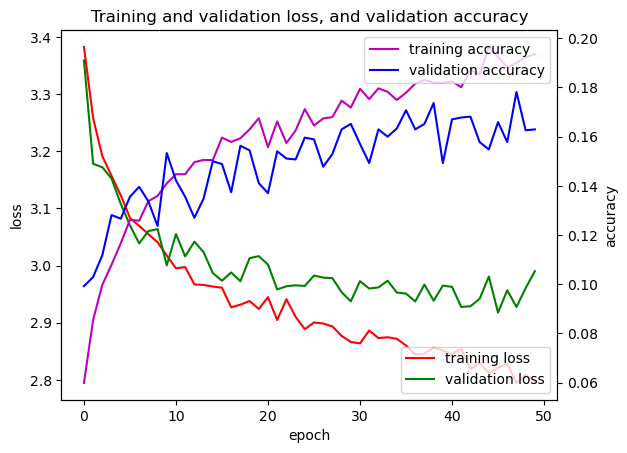

In [50]:
## MLP graph
mlp_result = torch.load(mlp.file_path)
fig_plot(result = mlp_result, name = 'mlp')

In [16]:
## Train CNN
cnn = CNN()
cnn.__net__()
# cnn.__shape__()
cnn.net.to(device)
cnn.__train__(nepochs = 50, res_path = "/kaggle/working/", lr = 0.001, file_name = 'CNN.pt')

epoch: 0 training loss:  3.402 training accuracy:  3.3%  test loss:  3.402 test accuracy:  2.6%
epoch: 1 training loss:  3.401 training accuracy:  3.5%  test loss:  3.402 test accuracy:  2.6%
epoch: 2 training loss:  3.401 training accuracy:  3.5%  test loss:  3.402 test accuracy:  2.6%
epoch: 3 training loss:  3.400 training accuracy:  3.6%  test loss:  3.401 test accuracy:  2.6%
epoch: 4 training loss:  3.397 training accuracy:  5.1%  test loss:  3.391 test accuracy:  6.4%
epoch: 5 training loss:  3.289 training accuracy:  8.2%  test loss:  3.166 test accuracy:  11.7%
epoch: 6 training loss:  3.087 training accuracy:  12.5%  test loss:  3.007 test accuracy:  15.1%
epoch: 7 training loss:  2.981 training accuracy:  15.7%  test loss:  2.968 test accuracy:  15.1%
epoch: 8 training loss:  2.905 training accuracy:  17.4%  test loss:  2.860 test accuracy:  19.0%
epoch: 9 training loss:  2.836 training accuracy:  19.9%  test loss:  2.847 test accuracy:  19.4%
epoch: 10 training loss:  2.741

<Figure size 640x480 with 0 Axes>

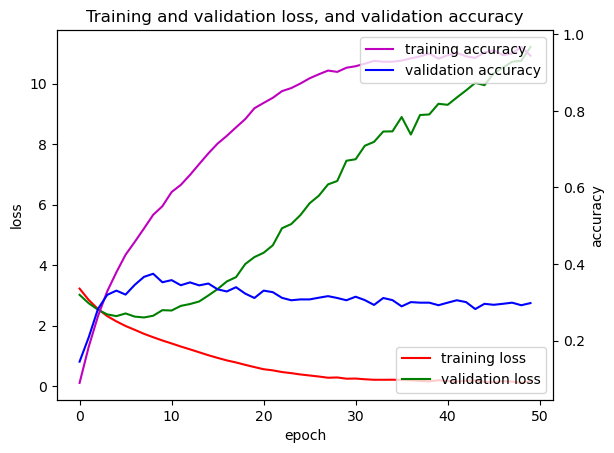

In [17]:
## CNN graph
cnn_result = torch.load("/kaggle/input/pt-files/CNN.pt")
fig_plot(result = cnn_result, name = 'cnn')

In [20]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in mlp.net.parameters())
print(f'{total_params:,} total parameters of MLP')

total_params = sum(p.numel() for p in cnn.net.parameters())
print(f'{total_params:,} total parameters of CNN')

3,695,730 total parameters of MLP
74,738 total parameters of CNN


> Comment on your model and results that should include number of parameters in each model and why CNN over MLP for image classification task?

#### Comment:
It can be obviously seen from the results that CNN is much more precise than MLP. Moreover, it requires much lower parameters than that (3,695,730 vs 74,738) so CNN can save time and resources  for image classification task.

### 2.2 Generating confusion matrix and ROC curves
- Use your CNN architecture with best accuracy to generate two confusion matrices, one for the training set and another for the validation set. Remember to use the whole validation and training sets, and to include all your relevant code. Display the confusion matrices in a meaningful way that clearly indicates what percentage of the data is represented in each position.
- Display ROC curve for 5 top classes with area under the curve

In [21]:
def accuracy(cnfm):
    return cnfm.trace()/cnfm.sum((0,1))

def recalls(cnfm):
    return np.diag(cnfm)/cnfm.sum(1)

def precisions(cnfm):
    return np.diag(cnfm)/cnfm.sum(0)

cnn_result = torch.load("/kaggle/input/pt-files/CNN.pt")
cnn.net.load_state_dict(cnn_result["state_dict"])
cnn.net.to(device)

# initialise confusion matrix
nclasses = len(data_set.class_name)
cnfm = np.zeros((nclasses,nclasses),dtype=int)

Confusion matrix of training set

Accuracy: 97.5%
Class (0) baboon : Precision 90.7%  Recall 99.7%
Class (1) banana : Precision 98.1%  Recall 98.3%
Class (2) bee : Precision 97.3%  Recall 98.9%
Class (3) bison : Precision 98.9%  Recall 99.2%
Class (4) butterfly : Precision 99.7%  Recall 98.9%
Class (5) candle : Precision 99.4%  Recall 86.6%
Class (6) cardigan : Precision 97.3%  Recall 99.7%
Class (7) chihuahua : Precision 96.5%  Recall 98.1%
Class (8) elephant : Precision 95.7%  Recall 100.0%
Class (9) espresso : Precision 99.1%  Recall 97.2%
Class (10) fly : Precision 97.8%  Recall 99.2%
Class (11) goldfish : Precision 97.3%  Recall 99.7%
Class (12) goose : Precision 97.9%  Recall 98.9%
Class (13) grasshopper : Precision 99.2%  Recall 99.2%
Class (14) hourglass : Precision 98.8%  Recall 95.2%
Class (15) icecream : Precision 97.7%  Recall 95.6%
Class (16) ipod : Precision 99.7%  Recall 98.0%
Class (17) jellyfish : Precision 98.9%  Recall 98.9%
Class (18) koala : Precision 99.1%  Recall

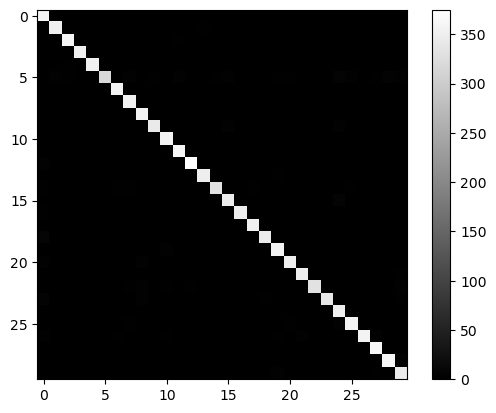

In [22]:
# CM of Training set
with torch.no_grad():
    for data in train_loader:
        images, labels, _ = data
        images, labels = images.to(device), labels.to(device)
        outputs = cnn.net(images)
        
        # find the class with the highest output.
        # note that the outputs are confidence values since we didn't need to apply softmax in our network
        # (nn.crossentropyloss takes raw condifence values and does its own softmax)   
        _, predicted = torch.max(outputs, 1)    
        
        # accumulate into confusion matrix
        for i in range(labels.size(0)):
            cnfm[labels[i].item(),predicted[i].item()] += 1
              
print("Confusion matrix of training set\n")

# show per-class recall and precision
print(f"Accuracy: {accuracy(cnfm) :.1%}")
r = recalls(cnfm)
p = precisions(cnfm)
for i in range(nclasses):
    print(f"Class ({i}) {data_set.class_name[i]} : Precision {p[i] :.1%}  Recall {r[i] :.1%}")

# show confusion matrix as a grey-level image
print("\nConfusion matrix as a grey-level image")
plt.imshow(cnfm, cmap='gray')
plt.colorbar()


Confusion matrix of validation set

Accuracy: 29.8%
Class (0) baboon : Precision 21.4%  Recall 30.0%
Class (1) banana : Precision 26.9%  Recall 27.5%
Class (2) bee : Precision 20.4%  Recall 23.0%
Class (3) bison : Precision 48.7%  Recall 39.4%
Class (4) butterfly : Precision 55.8%  Recall 46.7%
Class (5) candle : Precision 21.3%  Recall 15.7%
Class (6) cardigan : Precision 29.2%  Recall 33.3%
Class (7) chihuahua : Precision 10.8%  Recall 11.2%
Class (8) elephant : Precision 28.3%  Recall 31.9%
Class (9) espresso : Precision 39.0%  Recall 33.3%
Class (10) fly : Precision 29.1%  Recall 28.1%
Class (11) goldfish : Precision 41.7%  Recall 47.8%
Class (12) goose : Precision 26.8%  Recall 31.0%
Class (13) grasshopper : Precision 31.9%  Recall 29.9%
Class (14) hourglass : Precision 31.8%  Recall 21.4%
Class (15) icecream : Precision 8.6%  Recall 11.5%
Class (16) ipod : Precision 24.0%  Recall 18.9%
Class (17) jellyfish : Precision 72.7%  Recall 60.9%
Class (18) koala : Precision 44.2%  Recall

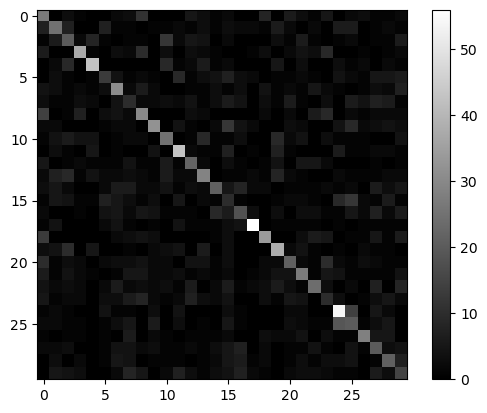

In [23]:
cnfm = np.zeros((nclasses,nclasses),dtype=int)

# CM of Validation set
with torch.no_grad():
    for data in valid_loader:
        images, labels, _ = data
        images, labels = images.to(device), labels.to(device)
        outputs = cnn.net(images)
        _, predicted = torch.max(outputs, 1)    
        
        # accumulate into confusion matrix
        for i in range(labels.size(0)):
            cnfm[labels[i].item(), predicted[i].item()] += 1
              
print("Confusion matrix of validation set\n")

# show per-class recall and precision
print(f"Accuracy: {accuracy(cnfm) :.1%}")
r = recalls(cnfm)
p = precisions(cnfm)
for i in range(nclasses):
    print(f"Class ({i}) {data_set.class_name[i]} : Precision {p[i] :.1%}  Recall {r[i] :.1%}")
    
# show confusion matrix as a grey-level image
print("\nConfusion matrix as a grey-level image")
plt.imshow(cnfm, cmap='gray')
plt.colorbar()

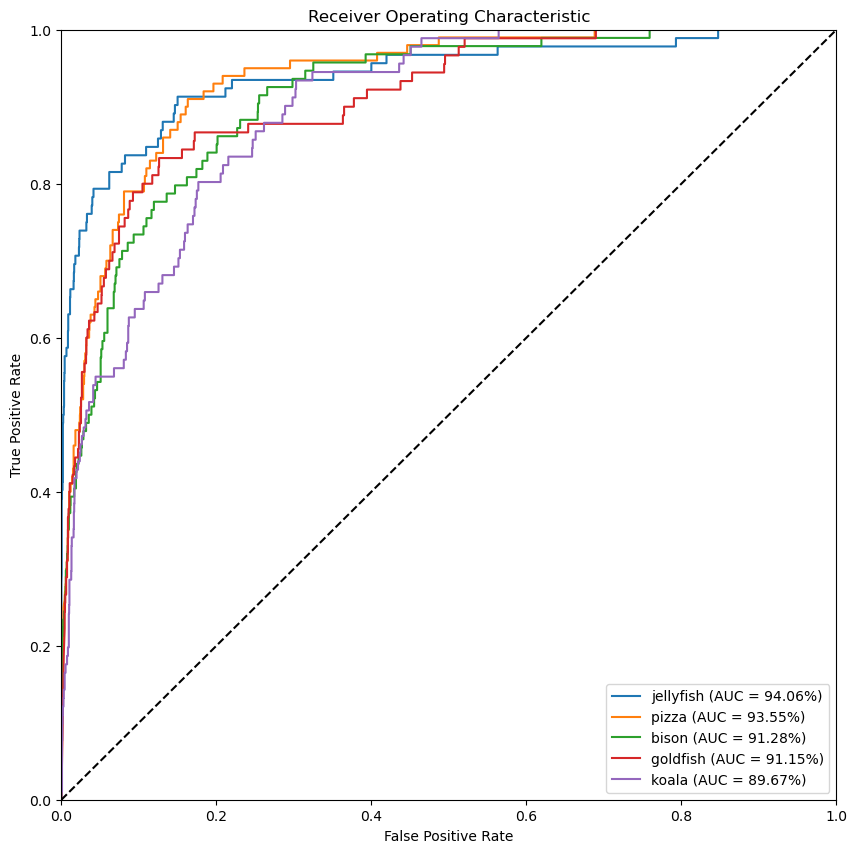

In [93]:
y = []
predicted_p = []

with torch.no_grad():
    for data in valid_loader:
        images, labels, _ = data
        images, labels = images.to(device), labels.to(device)
        outputs = cnn.net(images)
        predicted = torch.nn.functional.softmax(outputs, dim=1)
        y.extend(labels.cpu().numpy())
        predicted_p.extend(predicted.cpu().numpy())

y = np.array(y)
predicted_p = np.array(predicted_p)
fpr = {}
tpr = {}
roc_auc = {}
num_classes = len(data_set.class_name)
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y == i, predicted_p[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves for the top 5 classes with the highest AUC
plt.figure(figsize=(10, 10))
plt.title('Receiver Operating Characteristic')
for i in np.argsort(list(roc_auc.values()))[::-1][:5]:
    plt.plot(fpr[i], tpr[i], label = '{} (AUC = {:.2f}%)'.format(data_set.class_name[i], roc_auc[i]*100))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

**Note: All parts below here relate to the CNN model only and not the MLP! You are advised to use your final CNN model only for each of the following parts.**

### 2.3 Strategies for tackling overfitting
Using your (final) CNN model, use the strategies below to avoid overfitting. You can reuse the network weights from previous training, often referred to as ``fine tuning``. 
*   **2.3.1** Data augmentation
*   **2.3.2** Dropout
*   **2.3.3** Hyperparameter tuning (e.g. changing learning rate)

Plot loss and accuracy graphs per epoch side by side for each implemented strategy.

#### 2.3.1 Data augmentation

> Implement at least five different data augmentation techniques that should include both photometric and geometric augmentations. 

> Provide graph and comment on what you observe


In [31]:
## Data augmentation
trnsfrm = transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(hue = 0.1, saturation = 0.1, brightness = 0.1),
    transforms.RandomAffine(degrees = 10, translate = (0.1,0.1), scale = (0.9,1.0)),
    transforms.RandomHorizontalFlip(p = 0.5)
])

## Load data
data_set = Load_data(main_dir = "/kaggle/input/dl-coursework-1/data/train_set/train_set/", transform = trnsfrm)
train_loader, valid_loader = split_data(data_set = data_set, test_ratio = 0.2)

In [32]:
## Train CNN
cnn2 = CNN()
cnn2.__net__()
file_path = "/kaggle/input/pt-files/CNN.pt"
cnn2.net.load_state_dict(torch.load(file_path)['state_dict'])
# cnn2.__net__()
cnn2.net.to(device)
cnn2.__train__(nepochs = 50, res_path = "/kaggle/working/", lr = 0.001, file_name = 'CNN_aug.pt')

epoch: 0 training loss:  3.501 training accuracy:  6.2%  test loss:  3.295 test accuracy:  7.6%
epoch: 1 training loss:  3.180 training accuracy:  10.8%  test loss:  3.092 test accuracy:  13.9%
epoch: 2 training loss:  3.035 training accuracy:  14.2%  test loss:  2.968 test accuracy:  15.4%
epoch: 3 training loss:  2.951 training accuracy:  16.5%  test loss:  2.930 test accuracy:  17.2%
epoch: 4 training loss:  2.880 training accuracy:  18.0%  test loss:  2.962 test accuracy:  16.5%
epoch: 5 training loss:  2.825 training accuracy:  20.0%  test loss:  2.823 test accuracy:  20.0%
epoch: 6 training loss:  2.774 training accuracy:  20.9%  test loss:  2.812 test accuracy:  20.6%
epoch: 7 training loss:  2.732 training accuracy:  22.0%  test loss:  2.759 test accuracy:  21.1%
epoch: 8 training loss:  2.691 training accuracy:  22.9%  test loss:  2.731 test accuracy:  21.8%
epoch: 9 training loss:  2.665 training accuracy:  23.9%  test loss:  2.711 test accuracy:  22.7%
epoch: 10 training los

<Figure size 640x480 with 0 Axes>

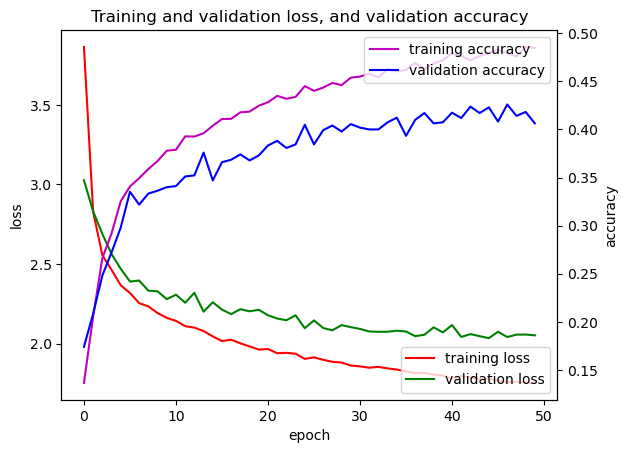

In [36]:
## CNN graph
cnn_aug_result = torch.load("/kaggle/input/pt-files/CNN_aug.pt")
fig_plot(result = cnn_aug_result, name = 'cnn_aug')

In [34]:
cnfm2 = np.zeros((nclasses,nclasses),dtype=int)
cnn2_result = torch.load("/kaggle/input/pt-files/CNN_aug.pt")
cnn2.net.load_state_dict(cnn2_result["state_dict"])
cnn2.net.to(device)
## CM of Training set
with torch.no_grad():
    for data in valid_loader:
        images, labels, _ = data
        images, labels = images.to(device), labels.to(device)
        outputs = cnn2.net(images)
          
        _, predicted = torch.max(outputs, 1)    
        
        # accumulate into confusion matrix
        for i in range(labels.size(0)):
            cnfm2[labels[i].item(),predicted[i].item()] += 1

#### Comment:
When using the data augmentation techique, the accuracy of the validation set is slightly higher and quite effective for overfitting but that of the training set suffers a drastic decline. In my opinion, we should do this method when the validation set accuracy seems to be nice and requires to add more preventing overfitting methods.

#### 2.3.2 Dropout

> Implement dropout in your model 

> Provide graph and comment on your choice of proportion used

In [61]:
## Drop out
cnn3 = CNN()
cnn3.__net__()
file_path = "/kaggle/input/pt-files/CNN.pt"
cnn3.net.load_state_dict(torch.load(file_path)['state_dict'])
cnn3.net = nn.Sequential(
    nn.Conv2d(in_channels=3,out_channels=8, kernel_size=3, padding = 1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=8,out_channels=12, kernel_size=3, padding = 1),
    nn.ReLU(),
    nn.Conv2d(in_channels=12,out_channels=16, kernel_size=3, padding = 1),
    nn.ReLU(),
    nn.Dropout(p = 0.5),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=16,out_channels=24, kernel_size=3, padding = 1),
    nn.ReLU(),
    nn.Conv2d(in_channels=24,out_channels=32, kernel_size=3, padding = 1),
    nn.ReLU(),
    nn.Dropout(p = 0.5),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Dropout(p = 0.5),
    nn.Linear(32*8*8, 30)
    )
cnn3.net.to(device)

Sequential(
  (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(8, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Dropout(p=0.5, inplace=False)
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Flatten(start_dim=1, end_dim=-1)
  (16): Dropout(p=0.5, inplace=False)
  (17): Linear(in_features=2048, out_features=30, bias=True)
)

In [63]:
## Load data
data_set = Load_data(main_dir = "/kaggle/input/dl-coursework-1/data/train_set/train_set/", transform = transforms.ToTensor())
train_loader, valid_loader = split_data(data_set = data_set, test_ratio = 0.2)

In [64]:
## Train CNN
cnn3.__train__(nepochs = 50, res_path = "/kaggle/working/CNN/", lr = 0.001, file_name = 'CNN_drop.pt')

epoch: 0 training loss:  3.169 training accuracy:  10.6%  test loss:  3.069 test accuracy:  13.3%
epoch: 1 training loss:  2.966 training accuracy:  15.7%  test loss:  2.933 test accuracy:  17.5%
epoch: 2 training loss:  2.846 training accuracy:  18.8%  test loss:  2.832 test accuracy:  19.1%
epoch: 3 training loss:  2.697 training accuracy:  22.2%  test loss:  2.666 test accuracy:  23.1%
epoch: 4 training loss:  2.600 training accuracy:  24.4%  test loss:  2.634 test accuracy:  24.1%
epoch: 5 training loss:  2.547 training accuracy:  26.4%  test loss:  2.600 test accuracy:  24.5%
epoch: 6 training loss:  2.485 training accuracy:  27.2%  test loss:  2.562 test accuracy:  25.1%
epoch: 7 training loss:  2.441 training accuracy:  28.7%  test loss:  2.606 test accuracy:  24.8%
epoch: 8 training loss:  2.390 training accuracy:  30.3%  test loss:  2.545 test accuracy:  25.5%
epoch: 9 training loss:  2.358 training accuracy:  31.7%  test loss:  2.542 test accuracy:  24.4%
epoch: 10 training l

<Figure size 640x480 with 0 Axes>

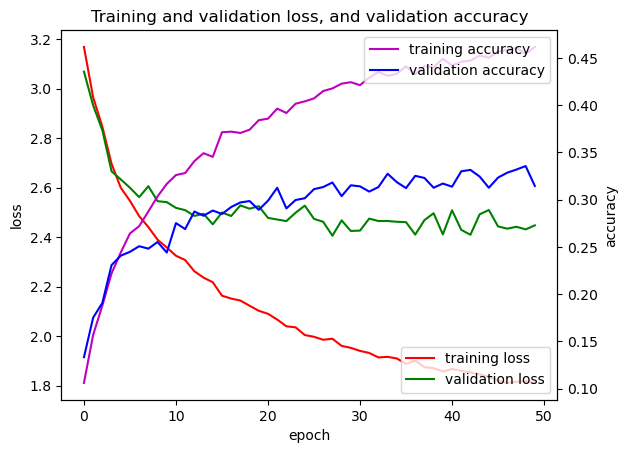

In [65]:
## CNN graph
cnn_drop_result = torch.load("/kaggle/input/pt-files/CNN_drop.pt")
fig_plot(result = cnn_drop_result, name = 'cnn_drop')

#### Comment:
The accuracy of validation set increases slightly and seems to be flucuation. It may be because the drop out randomly hide some node of the layer so certain parameters is not trained continuously. In overall, the accuracy is a little better compared with data augmentation.

#### 2.3.3 Hyperparameter tuning

> Use learning rates [0.1, 0.001, 0.0001]

> Provide separate graphs for loss and accuracy, each showing performance at three different learning rates

In [66]:
## Load data
data_set = Load_data(main_dir = "/kaggle/input/dl-coursework-1/data/train_set/train_set/", transform = transforms.ToTensor())
train_loader, valid_loader = split_data(data_set = data_set, test_ratio = 0.2)

In [67]:
## Train CNN
# lr1 = 0.1
cnn4 = CNN()
cnn4.__net__()
file_path = "/kaggle/input/pt-files/CNN.pt"
cnn4.net.load_state_dict(torch.load(file_path)['state_dict'])
# cnn4.__net__()
cnn4.net.to(device)
cnn4.__train__(nepochs = 50, res_path = "/kaggle/working/", lr = 0.1, file_name = 'CNN_lr1.pt')

# lr2 = 0.001
cnn5 = CNN()
cnn5.__net__()
file_path = "/kaggle/input/pt-files/CNN.pt"
cnn5.net.load_state_dict(torch.load(file_path)['state_dict'])
# cnn5.__net__()
cnn5.net.to(device)
cnn5.__train__(nepochs = 50, res_path = "/kaggle/working/", lr = 0.001, file_name = 'CNN_lr2.pt')

# lr3 = 0.0001
cnn6 = CNN()
cnn6.__net__()
file_path = "/kaggle/input/pt-files/CNN.pt"
cnn6.net.load_state_dict(torch.load(file_path)['state_dict'])
# cnn6.__net__()
cnn6.net.to(device)
cnn6.__train__(nepochs = 50, res_path = "/kaggle/working/", lr = 0.0001, file_name = 'CNN_lr3.pt')

epoch: 0 training loss:  12.455 training accuracy:  3.6%  test loss:  3.432 test accuracy:  3.3%
epoch: 1 training loss:  3.433 training accuracy:  3.2%  test loss:  3.428 test accuracy:  3.5%
epoch: 2 training loss:  3.435 training accuracy:  3.3%  test loss:  3.432 test accuracy:  3.3%
epoch: 3 training loss:  3.436 training accuracy:  3.2%  test loss:  3.425 test accuracy:  3.4%
epoch: 4 training loss:  3.438 training accuracy:  3.1%  test loss:  3.429 test accuracy:  3.5%
epoch: 5 training loss:  3.438 training accuracy:  3.2%  test loss:  3.423 test accuracy:  3.3%
epoch: 6 training loss:  3.435 training accuracy:  3.1%  test loss:  3.430 test accuracy:  3.6%
epoch: 7 training loss:  3.436 training accuracy:  3.0%  test loss:  3.440 test accuracy:  3.5%
epoch: 8 training loss:  3.433 training accuracy:  3.5%  test loss:  3.460 test accuracy:  2.7%
epoch: 9 training loss:  3.437 training accuracy:  3.4%  test loss:  3.443 test accuracy:  3.3%
epoch: 10 training loss:  3.436 trainin

Accuracy plot at learning rates = 0.1


<Figure size 640x480 with 0 Axes>

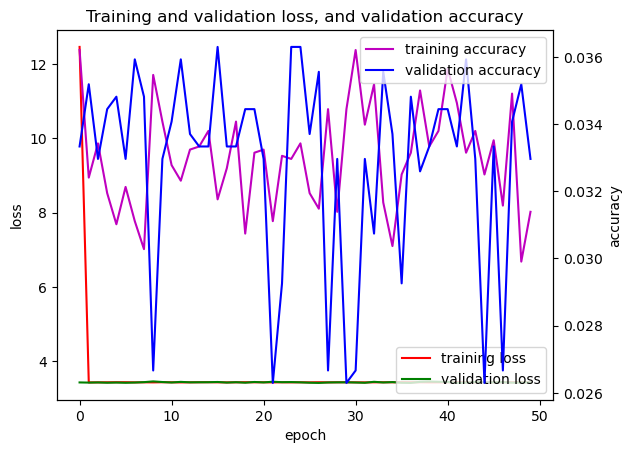

Accuracy plot at learning rates = 0.001


<Figure size 640x480 with 0 Axes>

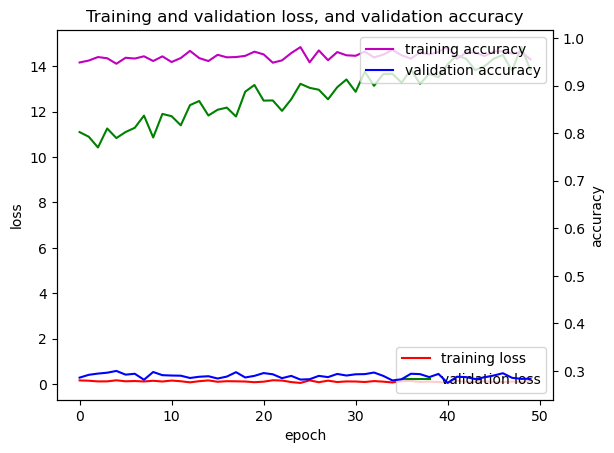

Accuracy plot at learning rates = 0.0001


<Figure size 640x480 with 0 Axes>

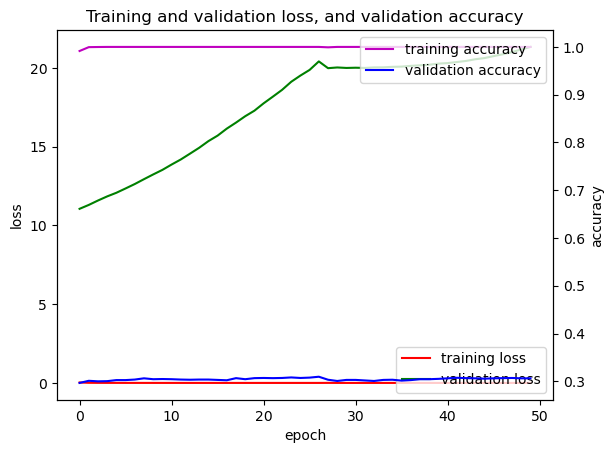

In [68]:
## CNN graph
print("Accuracy plot at learning rates = 0.1")
cnn_lr1_result = torch.load("/kaggle/input/pt-files/CNN_lr1.pt")
fig_plot(result = cnn_lr1_result, name = 'cnn_lr1')

print("Accuracy plot at learning rates = 0.001")
cnn_lr2_result = torch.load("/kaggle/input/pt-files/CNN_lr2.pt")
fig_plot(result = cnn_lr2_result, name = 'cnn_lr2')

print("Accuracy plot at learning rates = 0.0001")
cnn_lr3_result = torch.load("/kaggle/input/pt-files/CNN_lr3.pt")
fig_plot(result = cnn_lr3_result, name = 'cnn_lr3')


#### Comment:
If we choose too large learning rate, the model can't find the optimal point and get stuck with high values of error like learning rate at 0.1. In constrast, if the learning rate is too low, the model has not finded the optimal yet and has to run more epochs to find the minimum point showing as the result of learning rate at 0.0001. At learning rate being 0.001, the accuracy plot seems to be the most suitable among these learning rates.

### 3 Model testing
Online evaluation of your model performance on the test set.

> Prepare the dataloader for test set

> Write evaluation code for writing predictions

> Upload it to Kaggle submission page [link](https://www.kaggle.com/t/917fe52f6a3c4855880a24b34f26db07) 


#### 3.1 Test class and predictions

> Build a test class, prepare a test dataloader and generate predictions 

Create a PyTorch ```Dataset``` for the unlabeled test data in the test_set folder of the Kaggle competition and generate predictions using your final model. Test data can be downloaded [here](https://www.kaggle.com/competitions/comp5623m-artificial-intelligence/data?select=test_set)

In [69]:
## Load data
test_set = Load_test(main_dir = "/kaggle/input/dl-coursework-1/data/test_set/test_set/", transform = transforms.ToTensor())

# Batch and loader
test_batch = Batch(test_set)
test_loader = test_batch.__test__(batch_size = 16)

In [71]:
p = pd.DataFrame()
print(test_set)

In [73]:
## Generate predictions
predictions = []
f_names = []
with torch.no_grad():
    for data in test_loader:
        images, f_name = data
        images = images.to(device)
#         print(f_name)
        batch_size = len(f_name)
        outputs = cnn2.net(images)
        _, predicted = torch.max(outputs, 1)
#         print(predicted)
        for j in range(batch_size):
            f_names.append(f_name[j])
            predictions.append(int(predicted[j]))


#### 3.2 Prepare your submission and upload to Kaggle

Save all test predictions to a CSV file and submit it to the private class Kaggle competition. **Please save your test CSV file submissions using your student username (the one with letters, ie., ``sc15jb``, not the ID with only numbers)**, for example, `sc15jb.csv`. That will help us to identify your submissions.

The CSV file must contain only two columns: ‘Id’ and ‘Category’ (predicted class ID) as shown below:

```txt
Id,Category
28d0f5e9_373c.JPEG,2
bbe4895f_40bf.JPEG,18
```

Please note you will get marks for higher performance.

The ‘Id’ column should include the name of the image. It is important to keep the same name as the one on the test set. Do not include any path, just the name of file (with extension). Your csv file must contain 1501 rows, one for each image in the test set and 1 row for the headers. [To submit please visit](https://www.kaggle.com/t/917fe52f6a3c4855880a24b34f26db07)

> You may submit multiple times. We will use your personal top entry for allocating marks for this [8 marks]. The class leaderboard will not affect marking (brownie points!).


In [74]:
file_export = {"Id": f_names, "Category": predictions}
df = pd.DataFrame(file_export)
path_export = cnn.res_path + 'ml21ks3.csv'
df.to_csv(path_export, index=False, header=True)


### 4 Model Fine-tuning/transfer learning on CIFAR10 dataset 

Fine-tuning is a way of applying or utilizing transfer learning. It is a process that takes a model that has already been trained for one task and then tunes or tweaks the model to make it perform a second similar task. You can perform finetuning in the following way:
- Train an entire model from scratch (large dataset, more computation)
- Freeze convolution base and train only last FC layers (small dataset and lower computation) 

> **Configuring your dataset**
   - Download your dataset using ``torchvision.datasets.CIFAR10``, [explained here](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html)
   - Split training dataset into training and validation set similar to above. *Note that the number of categories here are only 10*


In [37]:
## Load data
root = "/kaggle/input/dl-coursework-1/data/cifar10/"
trnsfrm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224))
])

train_set = datasets.CIFAR10(
    root = root,
    train = True,
    download = True,
    transform = trnsfrm
)

valid_set = datasets.CIFAR10(
    root = root,
    train = False,
    download = True,
    transform = trnsfrm
)

train_loader = DataLoader(
    train_set,
    batch_size = 16,
    shuffle = True,
    num_workers = 2
)

valid_loader = DataLoader(
    valid_set,
    batch_size = 16, # Forward pass only so batch size can be larger
    shuffle = False,
    num_workers = 2
)

Files already downloaded and verified
Files already downloaded and verified


In [57]:
print(next(iter(train_loader))[0].size())

torch.Size([16, 3, 224, 224])


> Load pretrained AlexNet from PyTorch - use model copies to apply transfer learning in different configurations

In [38]:
class Alexnet():
    
    # Run AN model
    def __net__(self, n_class):
        model = models.alexnet(weights = "AlexNet_Weights.IMAGENET1K_V1")
        model.classifier[-1] = nn.Linear(4096, n_class)
        self.net = copy.deepcopy(model)
        
    # Parameter shape of model
    def __shape__(self):
        for param in self.net.parameters():
            print(param.shape)
        
    # Train model
    def __train__(self, nepochs, res_path, lr, file_name):
        os.makedirs(res_path, exist_ok=True)
        self.nepochs = nepochs
        self.res_path = res_path
        self.file_path = res_path + file_name
        statsrec = np.zeros((4, nepochs))
        loss_fn = nn.CrossEntropyLoss()
        optimizer = optim.SGD(self.net.parameters(), lr = lr, momentum = 0.9)
        start_t = time.time()
        
        for epoch in range(nepochs):
            correct = 0
            total = 0
            running_loss = 0.0
            n = 0
            for data in train_loader:
                if len(data) == 2:
                    inputs, labels = data
                    inputs, labels = inputs.to(device), labels.to(device)
                else:
                    inputs, labels, _ = data
                    inputs, labels = inputs.to(device), labels.to(device)
        
                # Zero the parameter gradients to remove accumulated gradient from a previous iteration.
                optimizer.zero_grad()

                # Forward, backward, and update parameters
                outputs = self.net(inputs)
                loss = loss_fn(outputs, labels)
                loss.backward()
                optimizer.step()

                # accumulate loss and increment minibatches
                running_loss += loss.item()
                n += 1
                
                # accumulate data for accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            # collect together statistics for this epoch
            ltrn = running_loss / n
            atrn = correct/total 
            ltst, atst = stats(valid_loader, self.net, loss_fn)
            ltst = ltst.cpu()
            statsrec[:,epoch] = (ltrn, atrn, ltst, atst)
            print(f"epoch: {epoch} training loss: {ltrn: .3f} training accuracy: {atrn: .1%}  test loss: {ltst: .3f} test accuracy: {atst: .1%}")

        # save network parameters and losses
        self.t = time.time() - start_t
        torch.save({"state_dict": self.net.state_dict(), "stats": statsrec}, self.file_path)

#### 4.1 Apply transfer learning initialise with pretrained model weights
Use pretrained weights from AlexNet only (on the right of figure) to initialise your model. 

<img src="https://upload.wikimedia.org/wikipedia/commons/c/cc/Comparison_image_neural_networks.svg" style="width:1000px;height:400px;">
<caption><center> <u>Figure</u>: Two models are given here: LeNet and AlexNet for image classification. However, you have to use **only AlexNet**.</center></caption>


> Configuration 1: No frozen layers

In [78]:
## Load pretrained Alexnet model
an1 = Alexnet()
an1.__net__(n_class = 10)
an1.net.to(device)

## Train model
an1.__train__(nepochs = 20, res_path = "/kaggle/working/", lr = 0.001, file_name = 'AN1.pt')

epoch: 0 training loss:  0.792 training accuracy:  72.3%  test loss:  0.585 test accuracy:  79.8%
epoch: 1 training loss:  0.469 training accuracy:  83.7%  test loss:  0.465 test accuracy:  83.7%
epoch: 2 training loss:  0.366 training accuracy:  87.3%  test loss:  0.461 test accuracy:  84.1%
epoch: 3 training loss:  0.293 training accuracy:  89.6%  test loss:  0.396 test accuracy:  86.6%
epoch: 4 training loss:  0.239 training accuracy:  91.7%  test loss:  0.398 test accuracy:  86.9%
epoch: 5 training loss:  0.200 training accuracy:  93.0%  test loss:  0.380 test accuracy:  87.7%
epoch: 6 training loss:  0.163 training accuracy:  94.2%  test loss:  0.386 test accuracy:  87.8%
epoch: 7 training loss:  0.135 training accuracy:  95.2%  test loss:  0.446 test accuracy:  86.7%
epoch: 8 training loss:  0.115 training accuracy:  95.9%  test loss:  0.424 test accuracy:  87.3%
epoch: 9 training loss:  0.098 training accuracy:  96.5%  test loss:  0.394 test accuracy:  88.5%
epoch: 10 training l

In [79]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in an1.net.parameters())
print(f'{total_params:,} total parameters')

total_trainable_params = sum(p.numel() for p in an1.net.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters')

57,044,810 total parameters
57,044,810 training parameters


#### 4.2 Fine-tuning model with frozen layers

> Configuration 2: Frozen base convolution blocks

In [59]:
## Load pretrained Alexnet model
an2 = Alexnet()
an2.__net__(n_class = 10)
an2.net.to(device)

## Frozen conv blocks
for par in an2.net.parameters():
    par.requires_grad = False
    
## Unforzen the last layer
for cf in an2.net.classifier:
    for par in cf.parameters():
        par.requires_grad = True

## Train model
an2.__train__(nepochs = 20, res_path = "/kaggle/working/", lr = 0.001, file_name = 'AN2.pt')

epoch: 0 training loss:  0.891 training accuracy:  69.0%  test loss:  0.699 test accuracy:  75.7%
epoch: 1 training loss:  0.616 training accuracy:  78.7%  test loss:  0.677 test accuracy:  76.8%
epoch: 2 training loss:  0.505 training accuracy:  82.6%  test loss:  0.675 test accuracy:  78.2%
epoch: 3 training loss:  0.424 training accuracy:  85.3%  test loss:  0.826 test accuracy:  75.9%
epoch: 4 training loss:  0.357 training accuracy:  87.5%  test loss:  0.743 test accuracy:  78.2%
epoch: 5 training loss:  0.307 training accuracy:  89.2%  test loss:  0.919 test accuracy:  76.0%
epoch: 6 training loss:  0.264 training accuracy:  90.9%  test loss:  0.899 test accuracy:  78.1%
epoch: 7 training loss:  0.238 training accuracy:  91.8%  test loss:  0.915 test accuracy:  78.0%
epoch: 8 training loss:  0.211 training accuracy:  92.8%  test loss:  1.066 test accuracy:  77.4%
epoch: 9 training loss:  0.186 training accuracy:  93.7%  test loss:  1.116 test accuracy:  78.9%
epoch: 10 training l

In [80]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in an2.net.parameters())
print(f'{total_params:,} total parameters')

total_trainable_params = sum(p.numel() for p in an2.net.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters')

57,044,810 total parameters
54,575,114 training parameters


#### 4.3 Compare above configurations and comment on comparative performance

AlexNet1 (No frozen layers)


<Figure size 640x480 with 0 Axes>

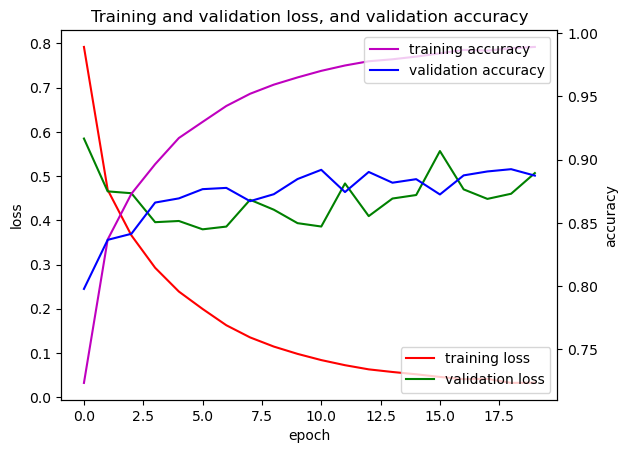

AlexNet2 (Frozen base convolution blocks)


<Figure size 640x480 with 0 Axes>

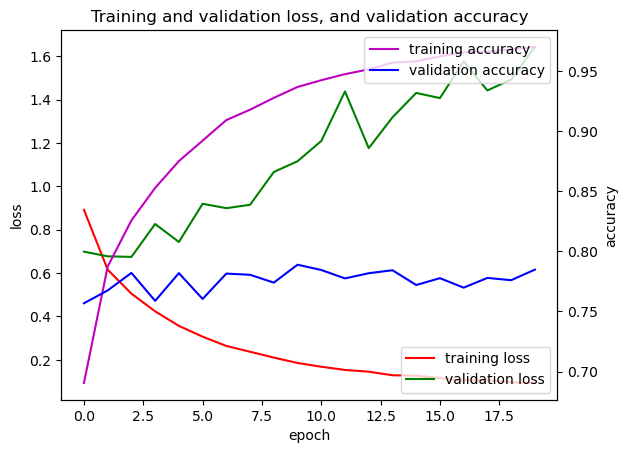

In [83]:
## AlexNet graph
print("AlexNet1 (No frozen layers)")
an1_result = torch.load("/kaggle/input/pt-files/AN1.pt")
fig_plot(result = an1_result, name = 'an1')

print("AlexNet2 (Frozen base convolution blocks)")
an2_result = torch.load("/kaggle/input/pt-files/AN2.pt")
fig_plot(result = an2_result, name = 'an2')

#### Comment: 
For the unfrozen layers, the accuracy is extremely high because it transfers the pretrained weights from Alexnet and adjust them to be suitable with cifar10 data set. However, if we perform the frozen full connecting layers in the last steps, the performance seems to be good but not equal to previous method. This is may because the training data of Alexnet might have some similarities but still contain differneces so if we want the higher accuracy, whole models should be retrained.

### 5 Model comparisons
We often need to compare our model with other state-of-the-art methods to understand how well it performs compared to existing architectures. Here you will thus compare your model design with AlexNet on the TinyImageNet30 dataset

#### 5.1 Finetune AlexNet on TinyImageNet30
> Load AlexNet as you did above

> Train AlexNet on TinyImageNet30 dataset until convergence. Make sure you use the same dataset

In [39]:
## Load data
trnsfrm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224))
])
data_set = Load_data(main_dir = "/kaggle/input/dl-coursework-1/data/train_set/train_set/", transform = trnsfrm)
train_loader, valid_loader = split_data(data_set = data_set, test_ratio = 0.2)

In [40]:
an3 = Alexnet()
an3.__net__(n_class = 30)
an3.net.to(device)
an3.__train__(nepochs = 50, res_path = "/kaggle/working/", lr = 0.001, file_name = 'AN3.pt')

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

epoch: 0 training loss:  1.600 training accuracy:  53.8%  test loss:  1.098 test accuracy:  67.6%
epoch: 1 training loss:  0.948 training accuracy:  71.5%  test loss:  0.983 test accuracy:  70.6%
epoch: 2 training loss:  0.721 training accuracy:  77.8%  test loss:  0.897 test accuracy:  72.6%
epoch: 3 training loss:  0.555 training accuracy:  82.5%  test loss:  0.884 test accuracy:  73.3%
epoch: 4 training loss:  0.416 training accuracy:  86.8%  test loss:  0.904 test accuracy:  74.3%
epoch: 5 training loss:  0.323 training accuracy:  89.8%  test loss:  0.911 test accuracy:  75.0%
epoch: 6 training loss:  0.248 training accuracy:  92.1%  test loss:  1.059 test accuracy:  73.2%
epoch: 7 training loss:  0.194 training accuracy:  93.7%  test loss:  0.978 test accuracy:  74.9%
epoch: 8 training loss:  0.156 training accuracy:  95.0%  test loss:  1.014 test accuracy:  75.3%
epoch: 9 training loss:  0.127 training accuracy:  95.8%  test loss:  1.089 test accuracy:  74.9%
epoch: 10 training l

#### 5.2 Compare results on validation set of TinyImageNet30
> Loss graph, top1 accuracy, confusion matrix and execution time for your model (say, mymodel and AlexNet)


Mymodel: 


<Figure size 640x480 with 0 Axes>

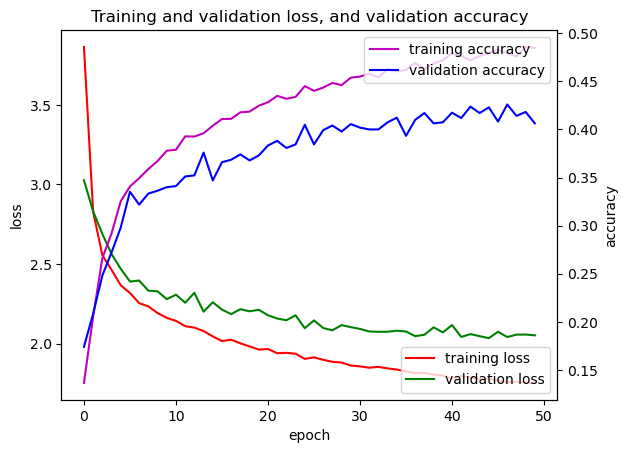

Confusion matrix of mymodel

Accuracy: 42.8%

Confusion matrix as a grey-level image
Mymodel execution time:  2615.25 seconds


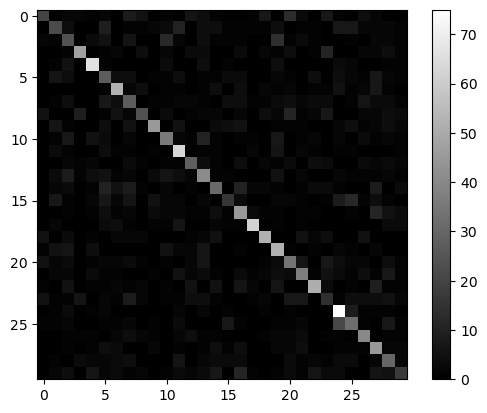

<Figure size 640x480 with 0 Axes>

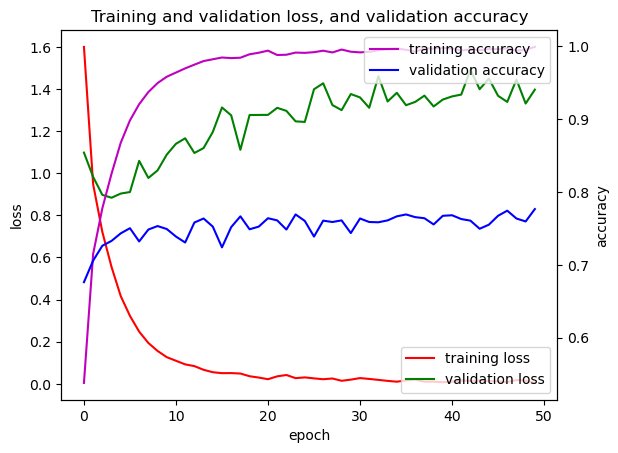

Confusion matrix of AlexNet

Accuracy: 77.7%

Confusion matrix as a grey-level image
AlexNet execution time:  2139.43 seconds


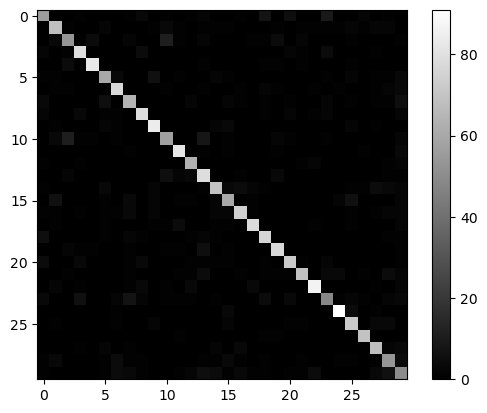

In [44]:
## Plot graph
# Mymodel (cnn2)
print("Mymodel: ")
cnn2_result = torch.load("/kaggle/input/pt-files/CNN_aug.pt")
fig_plot(result = cnn2_result, name = 'cnn2')

print("Confusion matrix of mymodel\n")
# show per-class recall and precision
print(f"Accuracy: {accuracy(cnfm2) :.1%}")

# show confusion matrix as a grey-level image
print("\nConfusion matrix as a grey-level image")
plt.imshow(cnfm2, cmap='gray')
plt.colorbar()

## Time consumed
print(f'Mymodel execution time: {cnn2.t : .2f} seconds')


# Alexnet
an3_result = torch.load(an3.file_path)
fig_plot(result = an3_result, name = 'an3')

cnfm3 = np.zeros((nclasses,nclasses),dtype=int)
## CM of Training set
with torch.no_grad():
    for data in valid_loader:
        images, labels, _ = data
        images, labels = images.to(device), labels.to(device)
        outputs = an3.net(images)
          
        _, predicted = torch.max(outputs, 1)    
        
        # accumulate into confusion matrix
        for i in range(labels.size(0)):
            cnfm3[labels[i].item(),predicted[i].item()] += 1
              
print("Confusion matrix of AlexNet\n")

# show per-class recall and precision
print(f"Accuracy: {accuracy(cnfm3) :.1%}")

# show confusion matrix as a grey-level image
print("\nConfusion matrix as a grey-level image")
plt.imshow(cnfm3, cmap='gray')
plt.colorbar()


## Time consumed
print(f'AlexNet execution time: {an3.t : .2f} seconds')

### 6 Interpretation of results 

> Please use TinyImageNet30 dataset for all results


#### 6.1-6.2 Implement grad-CAM and visualise results

- Use an existing library to initiate grad-CAM 

        - To install: !pip install torchcam
        - Call SmoothGradCAMpp: from torchcam.methods import SmoothGradCAMpp
        - Apply to your model 

You can see the details here: https://github.com/frgfm/torch-cam

- Apply grad-CAM to your model on at least four correctly classified images
- Apply grad-CAM on retrained AlexNet on at least four incorrectly classified images

>It is recommended to first read the relevant paper [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391), and refer to relevant course material.


**HINT for displaying images with grad-CAM:**

Display ```heatmap``` as a coloured heatmap superimposed onto the original image. We recommend the following steps to get a clear meaningful display. 

From torchcam.utils import overlay_mask. But remember to resize your image, normalise it and put a 1 for the batch dimension (e.g, [1, 3, 224, 224]) 


In [45]:
!pip install torchcam
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
from torchvision.io.image import read_image

In [46]:
## Apply model
cnn2 = CNN()
cnn2.__net__()
file_path = "/kaggle/input/pt-files/CNN_aug.pt"
cnn2.net.load_state_dict(torch.load(file_path)['state_dict'])
cnn2.net.to(device)
cnn2.net.eval()

an3 = Alexnet()
an3.__net__(n_class = 30)
file_path = "/kaggle/input/pt-files/AN3.pt"
an3.net.load_state_dict(torch.load(file_path)['state_dict'])
an3.net.to(device)
an3.net.eval()

In [60]:
## Correct the target files
cor_img = []
inc_img = []

## Load data
data_set = Load_data(main_dir = "/kaggle/input/dl-coursework-1/data/train_set/train_set/", transform = transforms.ToTensor())
train_loader, valid_loader = split_data(data_set = data_set, test_ratio = 0.2)

with torch.no_grad():
    for data in valid_loader:
        if len(cor_img) < 4:
            images, labels, f_name = data
            images, labels = images.to(device), labels.to(device)
            outputs = cnn2.net(images)

            _, predicted = torch.max(outputs, 1)    

            for i in range(labels.size(0)):
                if labels[i] == predicted[i]:
                    cor_img.append(f_name[i])

## Load data
trnsfrm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224))
])
data_set = Load_data(main_dir = "/kaggle/input/dl-coursework-1/data/train_set/train_set/", transform = trnsfrm)
train_loader, valid_loader = split_data(data_set = data_set, test_ratio = 0.2)
                    
with torch.no_grad():
    for data in valid_loader:
        if len(inc_img) < 4:
            images, labels, f_name = data
            images, labels = images.to(device), labels.to(device)
            outputs = an3.net(images)

            _, predicted = torch.max(outputs, 1)    

            for i in range(labels.size(0)):
                if labels[i] != predicted[i]:
                    inc_img.append(f_name[i])

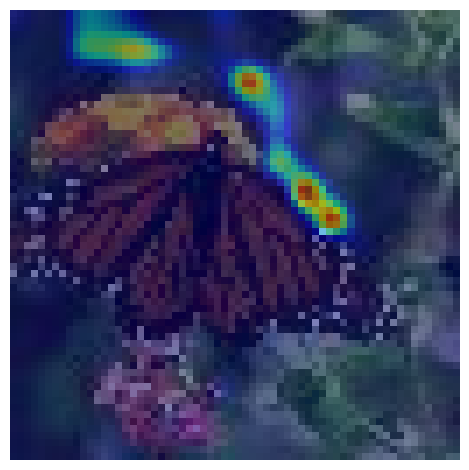

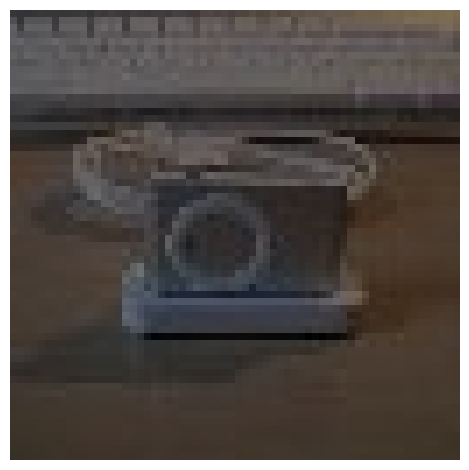

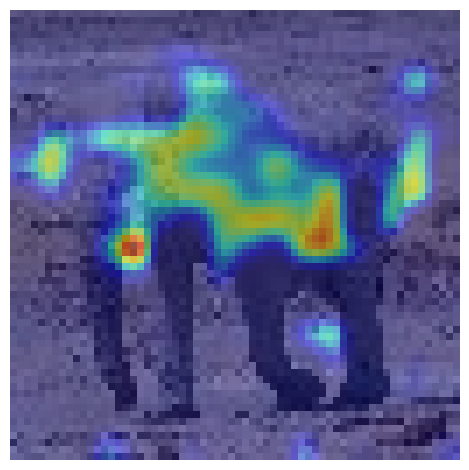

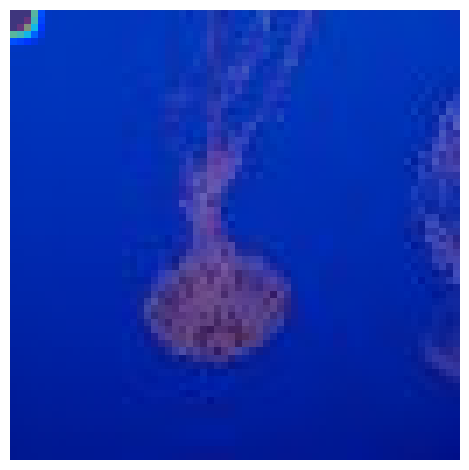

In [167]:
for img in range(4):
    find_loc = "/kaggle/input/dl-coursework-1/data/train_set/train_set/*/"
    img_loc = ' '.join(glob.glob(os.path.join(find_loc, cor_img[img])))
    model = cnn2.net.cpu()
    cam_extractor = SmoothGradCAMpp(model = model, target_layer = '10')
    img = read_image(img_loc)
    # Preprocess it for your chosen model
    input_tensor = normalize(img / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    # Preprocess your data and feed it to the model
    out = model(input_tensor.unsqueeze(0))
    # Retrieve the CAM by passing the class index and the model output
    activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

    # Resize the CAM and overlay it
    result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)
    # Display it
    plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()

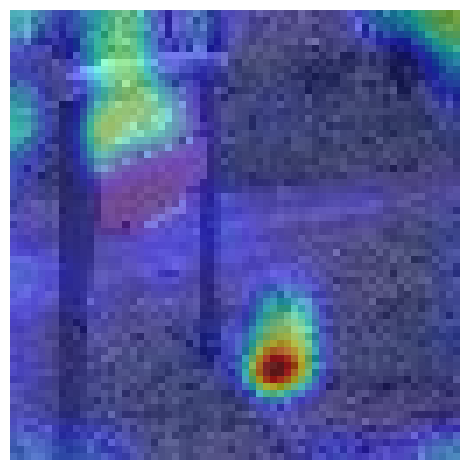

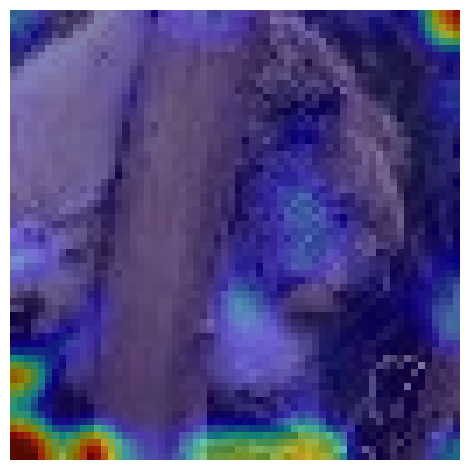

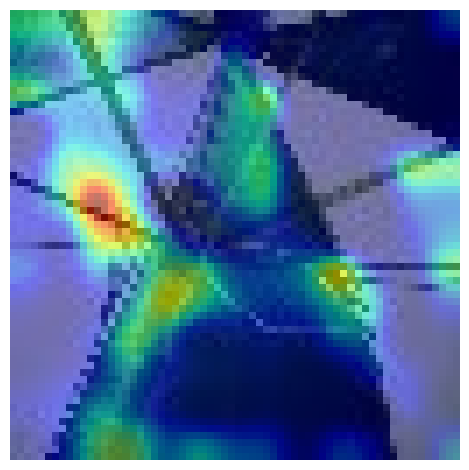

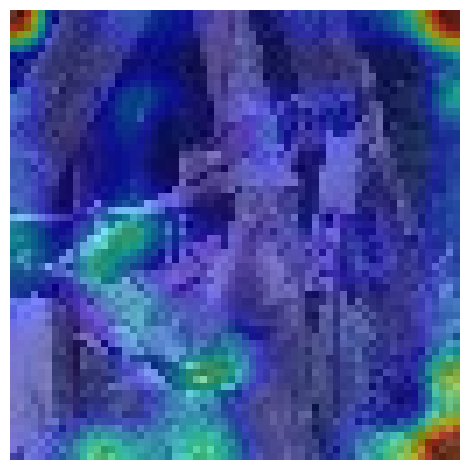

In [174]:
for img in range(4):
    find_loc = "/kaggle/input/dl-coursework-1/data/train_set/train_set/*/"
    img_loc = ' '.join(glob.glob(os.path.join(find_loc, inc_img[img])))
    model = an3.net.cpu()
    cam_extractor = SmoothGradCAMpp(model = model, target_layer = 'features.10')
    img = read_image(img_loc)
    # Preprocess it for your chosen model
    input_tensor = normalize(resize(img,(224, 224) )/ 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    # Preprocess your data and feed it to the model
    out = model(input_tensor.unsqueeze(0))
    # Retrieve the CAM by passing the class index and the model output
    activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

    # Resize the CAM and overlay it
    result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)
    # Display it
    plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()

#### 6.3 Your comments on:
> a) Why model predictions were correct or incorrect? You can support your case from 6.2

> b) What can you do to improve your results further?

---> 
a) The features which are correct classifier, they seem to capture the border or the body of the object precisely. However, for incorrectly classified pictures, they focus on the background of the picture because almost all the picture contain the component of object so the model may think wrongly that the object is background and background is object.
b) We should apply more data augmentation, for example cropping or expanding the picture, and another possible wayout is increase the set of pictures in various aspects including smaller and bigger pictures of the same things.

**Please refer to the submission section at the top of this notebook to prepare your submission. Use our teams channel to seek any help!**
